<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Text Classification Using Random Forest Classifier And Tfidf Vectorizer

### Text Classification using Random Forest Classifier along with the Text Feature technique TfidfVectorizer from Scikit-learn in python.

### Required Packages

In [ ]:
!pip install nltk
!pip install imblearn

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as se
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier

### Initialization

Filepath of CSV file

In [3]:
#filepath
file_path= ""

**Target** variable for prediction.

In [4]:
target=''

Text column containing all the text data


In [5]:
text=""

## Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [6]:
df=pd.read_csv(file_path)
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [7]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# STEMMING
# Initialize the Stemmer
ps = PorterStemmer()

# Stem the sentence
def stemmer(string):
    return ps.stem(string)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Lemmatize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def textlemmapreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

def textstempreprocess(string):
    return stemmer(stopword(preprocess(string)))

def textfinalpreprocess(df, modifier = 'stemmer'):
    if modifier == 'lemmatization':
        return(df[text].apply(lambda x: textlemmapreprocess(x)))
    elif modifier == 'stemmer':
        return(df[text].apply(lambda x: textstempreprocess(x)))

def data_preprocess(df, target):
    df = df.dropna(axis=0, how = 'any')
    df[target] = LabelEncoder().fit_transform(df[target])    
    return df

In [8]:
df = data_preprocess(df, target)
df[text] = textfinalpreprocess(df, modifier = 'stemmer') #modifier has two options: 'stemmer', 'lemmatization'
df.head()

,Review,Liked
0,wow loved plac,1
1,crust good,0
2,tasty texture nasti,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great pric,1


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [9]:
X=df[text]
Y=df[target]

#### Distribution Of Target Variable

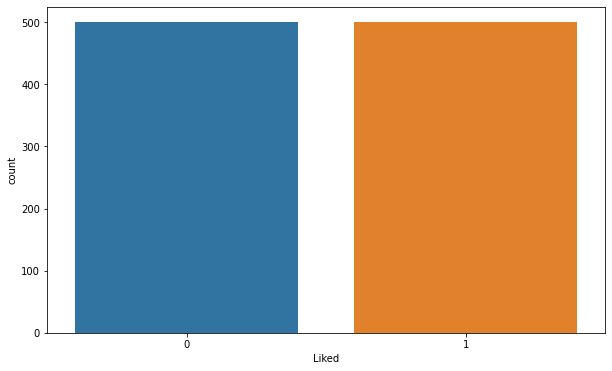

In [10]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Data Splitting
Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### Feature Transformation

**TfidfVectorizer** converts a collection of raw documents to a matrix of TF-IDF features.

It's equivalent to CountVectorizer followed by TfidfTransformer.

For more information on TfidfVectorizer [click here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [12]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

## Model

Random Forest for classification.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.



#### Model Tuning Parameters

    1.n_estimatorsint, default=100
>The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

    2.criterion{“gini, “entropy}, default=gini
>The function to measure the quality of a split. Supported criteria are “gini for the Gini impurity and “entropy for the information gain. Note: this parameter is tree-specific.

    3.max_depthint, default=None
>The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

    4.min_samples_splitint or float, default=2
>The minimum number of samples required to split an internal node:

If int, then consider min_samples_split as the minimum number.

If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.


    5.min_weight_fraction_leaffloat, default=0.0
>The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.


For more information on RandomForestClassifier and it's parameters [click here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [13]:
model=RandomForestClassifier(n_estimators=500, random_state=123)
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

#### Model Accuracy
score() method return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [14]:
print("Accuracy score {:.2f} %\n".format(model.score(x_test,y_test)*100))

Accuracy score 75.50 %



#### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

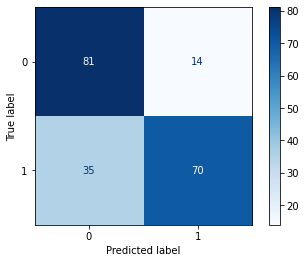

In [15]:
plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.
* where:
  - Precision:- Accuracy of positive predictions.
  -  Recall:- Fraction of positives that were correctly identified.
  -  f1-score:- percent of positive predictions were correct
  -  support:- Support is the number of actual occurrences of the class in the specified dataset.

In [16]:
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        95
           1       0.83      0.67      0.74       105

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.75       200
weighted avg       0.77      0.76      0.75       200



#### Creator: Arpit Somani, Github: [Profile](https://github.com/arpitsomani8)